#  This is Lab 2 executable file
This file contains the program code that is the solution to the tasks from the file [lab_2_task.txt](https://github.com/vandosik/M-M-MSA/blob/master/Lab_2/lab_2_task.txt).
## Authors
* Ivan Dubinin: [vandosik](https://github.com/vandosik)
* Alexey Grandilevskii: [zer0deck](https://github.com/zer0deck)
* Mikhail Sorokin: [Mikha1lSorokin](https://github.com/Mikha1lSorokin)

In [1]:
# libs initialization
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import pandas as pd
import numpy as np
import scipy as sp
import pylab

from datetime import datetime
from prettytable import PrettyTable

from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Dataset initialization
path_to_file = '../Datasets/Challenger_Ranked_Games.csv'
source_df = pd.read_csv(path_to_file, engine='python')
# source_df.columns = ["V"+str(i) for i in range(1, len(source_df.columns)+1)]  # rename column names to be similar to R naming convention
# source_df.V2 = source_df.V2.astype(str)
source_df.head(7)

,gameId,gameDuraton,blueWins,blueFirstBlood,blueFirstTower,blueFirstBaron,blueFirstDragon,blueFirstInhibitor,blueDragonKills,blueBaronKills,...,redAssist,redChampionDamageDealt,redTotalGold,redTotalMinionKills,redTotalLevel,redAvgLevel,redJungleMinionKills,redKillingSpree,redTotalHeal,redObjectDamageDealt
0,4247263043,1323,0,1,0,0,0,0,0,0,...,68,73016,49832,533,64,12.8,138,8,38711,60463
1,4247155821,1317,1,0,0,0,1,0,2,0,...,8,44218,37136,571,59,11.8,134,3,24829,14105
2,4243963257,932,0,0,0,0,0,0,0,0,...,20,30797,35364,400,50,10.0,89,5,12589,45201
3,4241678498,2098,0,0,0,1,1,0,1,1,...,72,125866,70528,832,84,16.8,205,9,65312,88202
4,4241538868,2344,1,1,1,1,1,1,2,2,...,83,131536,74596,794,85,17.0,227,7,86431,64141
5,4241394461,1567,1,1,1,0,0,1,2,0,...,34,64242,44280,555,61,12.2,140,3,23741,20132
6,4233222221,1686,0,0,1,0,0,0,0,0,...,59,78424,58032,640,73,14.6,214,5,31415,61040


In [3]:
# Colums renaming and data preparation
source_df = source_df[['gameDuraton', # this is the value we will predict (target)
                        'blueWins', # this is our category sorter
                        'blueWardPlaced', # all other values are the predictors
                        'blueWardkills', 
                        'blueKills', 
                        'blueDeath', 
                        'blueChampionDamageDealt', 
                        'blueTotalGold', 
                        'blueTotalMinionKills', 
                        'blueJungleMinionKills',
                        'blueTotalHeal',
                        'blueObjectDamageDealt']]

# show new dataset
source_df.head(7)


,gameDuraton,blueWins,blueWardPlaced,blueWardkills,blueKills,blueDeath,blueChampionDamageDealt,blueTotalGold,blueTotalMinionKills,blueJungleMinionKills,blueTotalHeal,blueObjectDamageDealt
0,22.050000,0,38,13,15,31,56.039,37.001,440,105,31.035,5.675
1,21.950000,1,57,18,19,8,60.243,41.072,531,111,26.397,45.303
2,15.533333,0,28,7,5,20,24.014,22.929,306,64,6.567,5.651
3,34.966667,0,129,39,26,36,101.607,63.447,774,226,24.718,31.019
4,39.066667,1,114,35,27,40,134.826,74.955,831,252,37.161,95.287
5,26.116667,1,65,23,26,18,59.839,52.221,576,171,40.925,51.855
6,28.100000,0,72,26,16,31,70.270,47.107,601,136,20.503,31.788


In [4]:
# plt.figure(figsize=(13, 8))

# kernel = scipy.stats.gaussian_kde(source_df['game_length'])

# min_amount, max_amount = source_df['game_length'].min(), source_df['game_length'].max()
# x = np.linspace(min_amount, max_amount, len(source_df)) # by defaul 50 items
# kde_values = kernel(x)

# # sns.histplot(source_df[col_name], kde=False, stat="density", label=f'Average transaction size in rubles')
# # Draw unnormed histogramm
# hist_data = plt.hist(source_df['game_length'], density=True, bins=50)

# # print(hist_vals)
# plt.plot(x, kde_values, color="r")

# plt.ylabel('p')
# plt.xlabel('Average transaction size')

# plt.legend()
# plt.show()

## Exercise №1
You need to make a non-parametric estimation of PDF in form of histogram and using kernel density function for MRV (or probability law in case of discrete MRV).

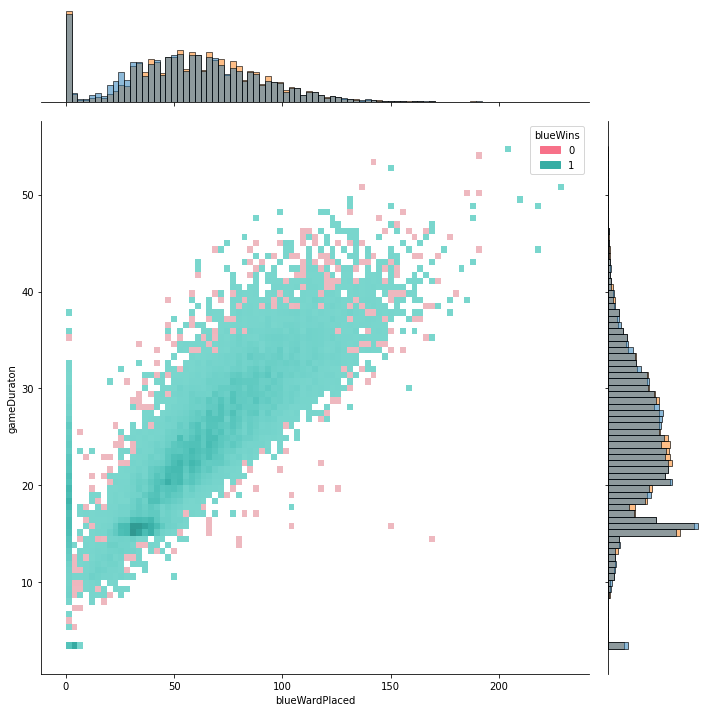

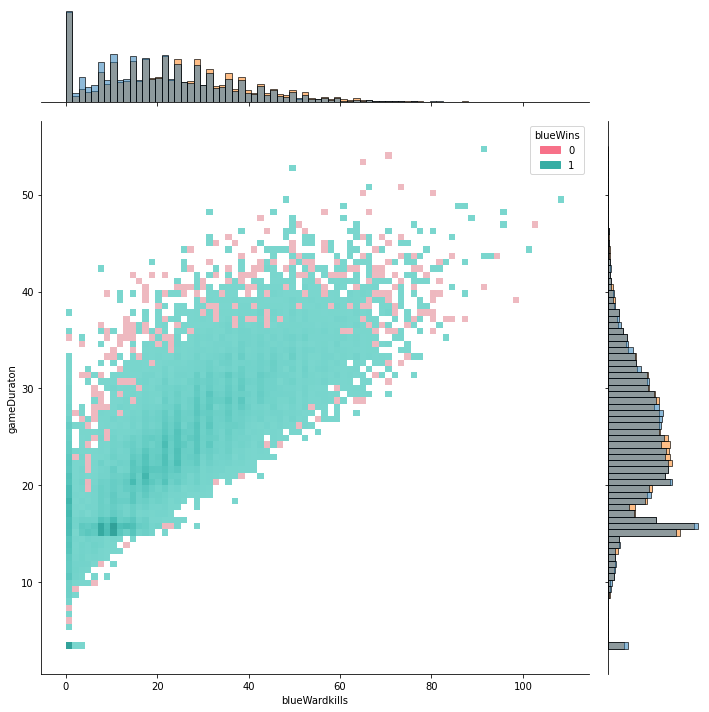

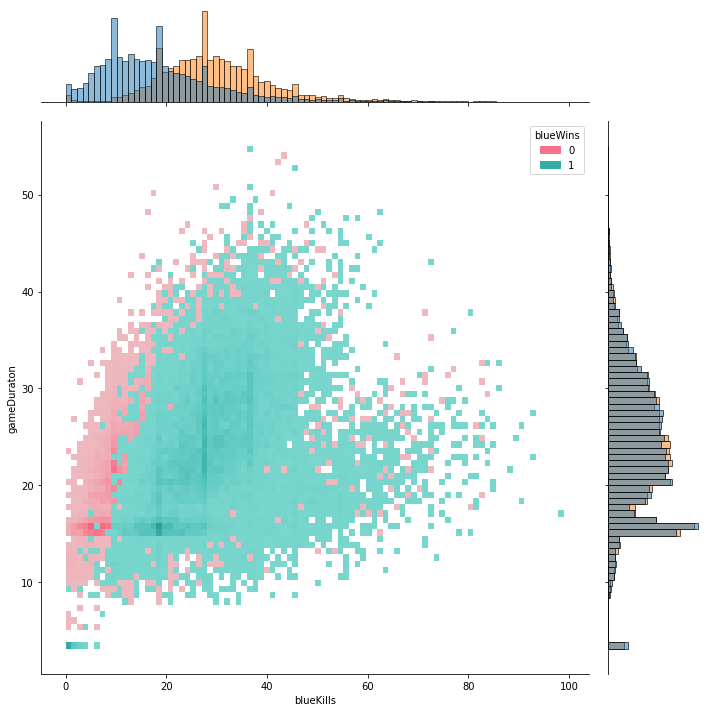

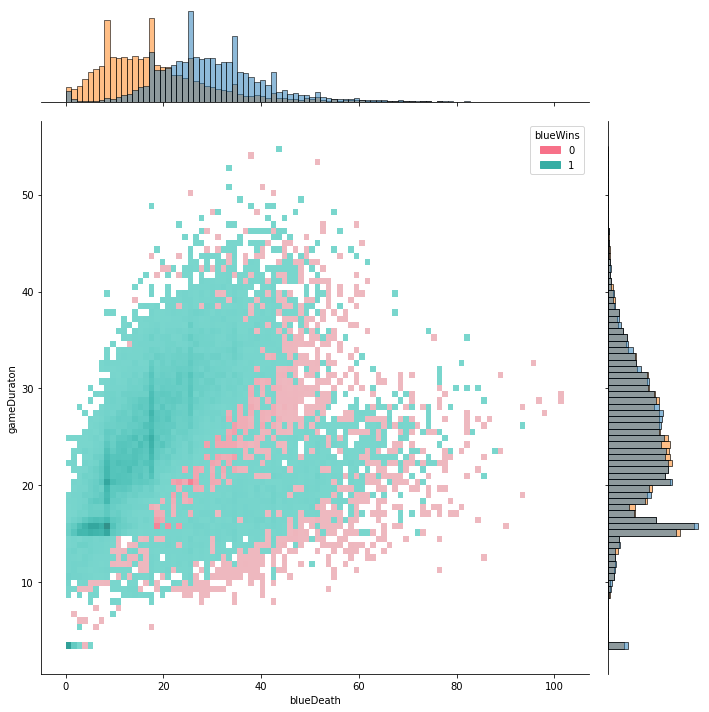

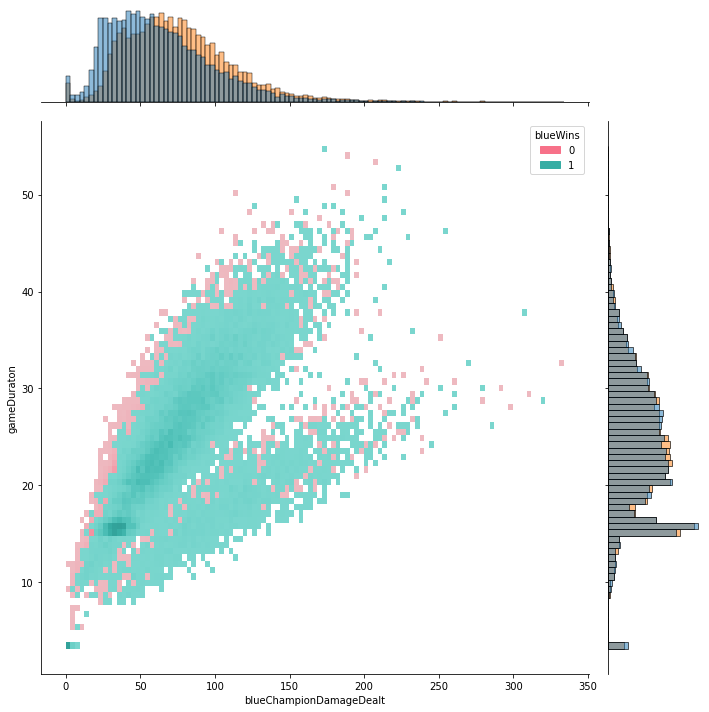

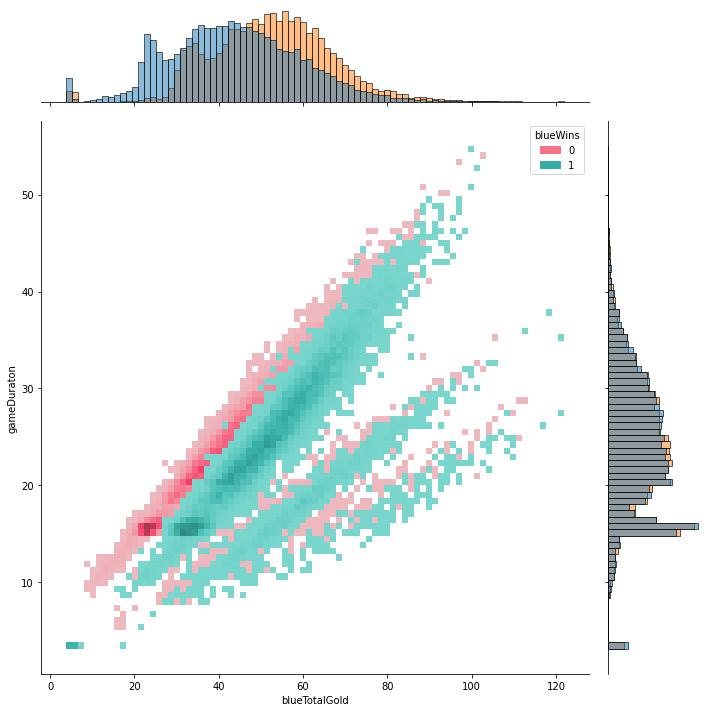

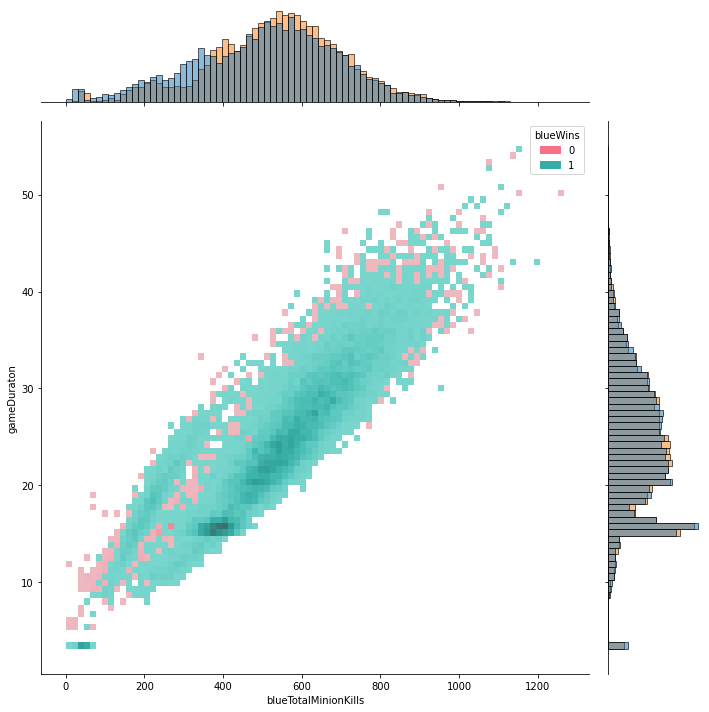

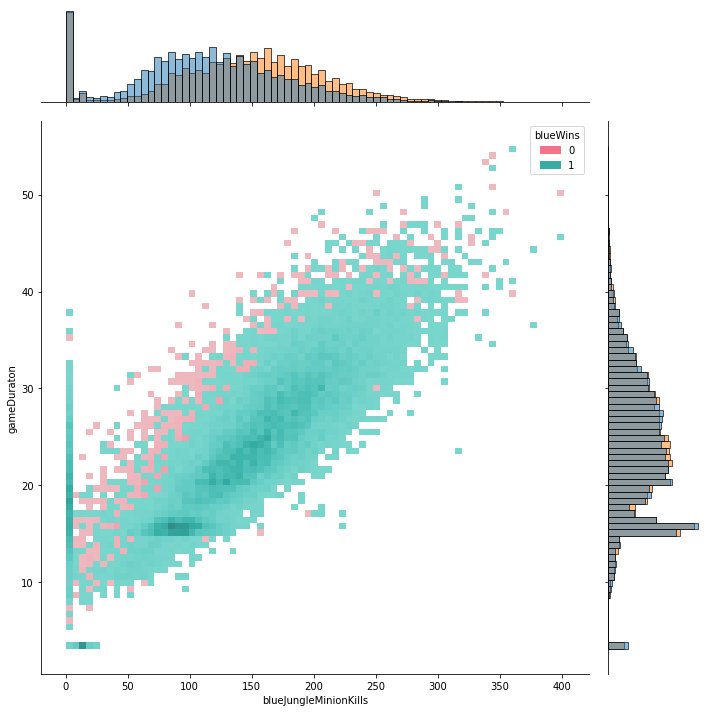

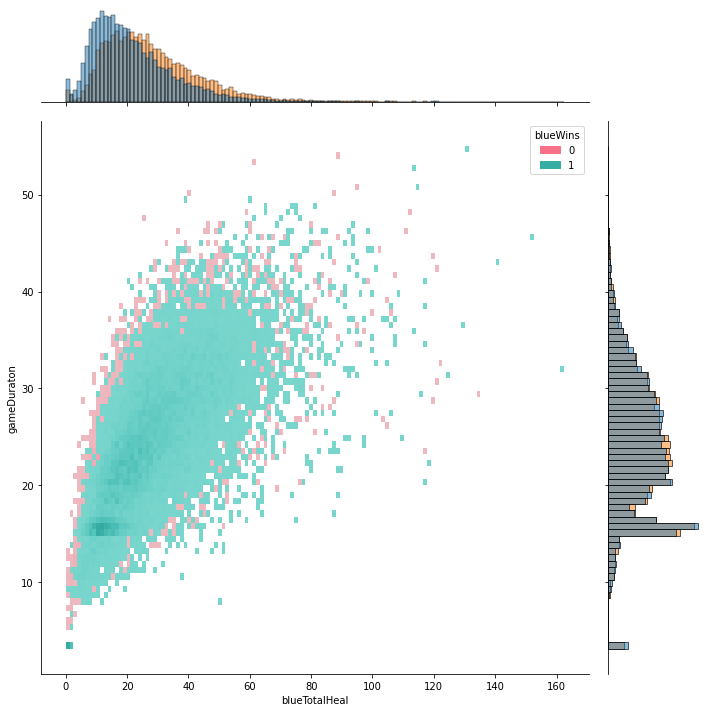

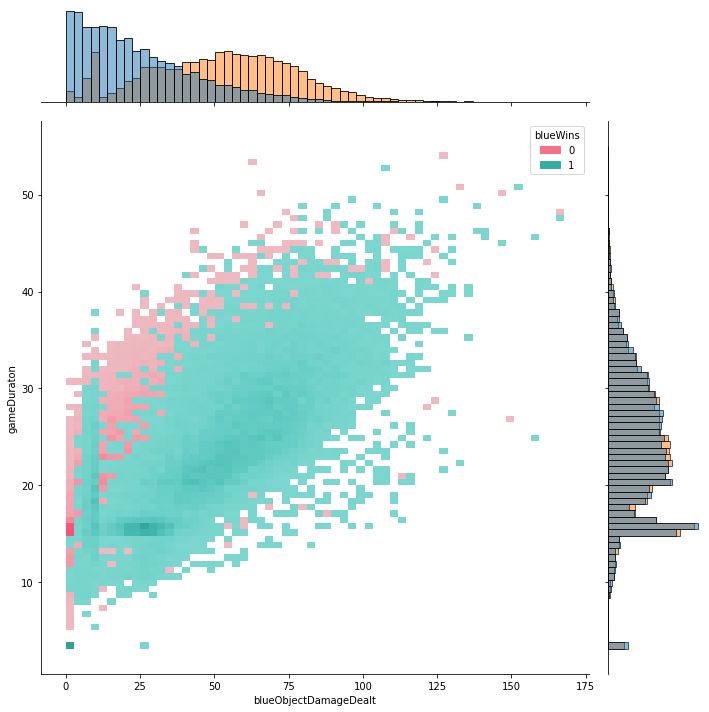

In [5]:
ilist = source_df.columns.tolist()
for i in range(2, len(ilist)):
    sns.jointplot(data=source_df, x=ilist[i], y='gameDuraton', hue='blueWins', height=10, kind="hist", palette="husl")
    

## Exercise №2
You need to make an estimation of multivariate mathematical expectation and variance.

In [6]:
table = PrettyTable()
table.field_names = ["Column name", "mathematical expectation", "variance"]
for i in range(0, len(ilist)-1):
    table.add_row([str(ilist[i]), str(source_df.mean()[i]), str(source_df.var()[i])])
print(table)

+-------------------------+--------------------------+---------------------+
|       Column name       | mathematical expectation |       variance      |
+-------------------------+--------------------------+---------------------+
|       gameDuraton       |    24.14422762414511     |  49.60321233051361  |
|         blueWins        |    0.5000743383883437    | 0.25000928711754167 |
|      blueWardPlaced     |    58.64035087719298     |  982.9231697241096  |
|      blueWardkills      |    22.330136782634554    |  240.32047448599184 |
|        blueKills        |    24.18941421349985     |  167.81358009025033 |
|        blueDeath        |    24.180567945286946    |  170.11615064943672 |
| blueChampionDamageDealt |     69.746341882248      |  1279.0189829913902 |
|      blueTotalGold      |    48.16912990633363     |  239.51386762751284 |
|   blueTotalMinionKills  |     520.446587867975     |  30965.83865170302  |
|  blueJungleMinionKills  |     129.586938745168     |  4181.303298898823  |

## Exercise №3
You need to make a non-parametric estimation of conditional distributions, mathematical expectations and variances. 

<Figure size 1800x1080 with 0 Axes>

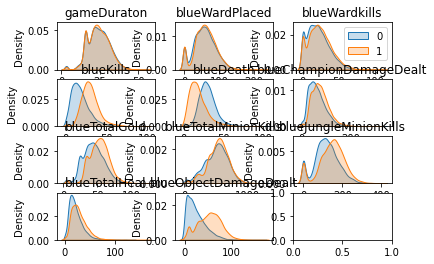

In [7]:
# list of variables without bluewins
w = ['gameDuraton',
    'blueWardPlaced',
    'blueWardkills', 
    'blueKills', 
    'blueDeath', 
    'blueChampionDamageDealt', 
    'blueTotalGold', 
    'blueTotalMinionKills', 
    'blueJungleMinionKills',
    'blueTotalHeal',
    'blueObjectDamageDealt']

# we make only 5 most popular maps estimation otherwise the graphs will become unreadable
fig = plt.figure(figsize=(25,15))
plt.subplots(4, 3)
for i, col in enumerate(w):
    plt.subplot(4, 3, i+1)
    sns.kdeplot(source_df.loc[source_df['blueWins'] == 0, col], shade=True, label='0', warn_singular=False)
    sns.kdeplot(source_df.loc[source_df['blueWins'] == 1, col], shade=True, label="1", warn_singular=False)
    plt.xlabel('')
    plt.title(col)
    if i == 2:
        plt.legend(loc='upper right')
    else:
        plt.legend().remove()
plt.show()

In [8]:
# output mean and var grouped by maps
bluewins_df = source_df.groupby('blueWins')
table = PrettyTable()
table.field_names = ["Win or not", "Column name", "m.expectation", "variance"]
for blueWins, group in bluewins_df:
    table.add_row([blueWins, w[0], str(group[w[0]].mean())[:10], str(group[w[0]].var())[:10]])
    for i in range (1, len(w)):
        table.add_row(['', w[i], str(group[w[i]].mean())[:10], str(group[w[i]].var())[:10]])
table.align["Column name"] = 'l'
print(table)

+------------+-------------------------+---------------+------------+
| Win or not | Column name             | m.expectation |  variance  |
+------------+-------------------------+---------------+------------+
|     0      | gameDuraton             |   24.1541908  | 50.5142995 |
|            | blueWardPlaced          |   57.4631970  | 985.511211 |
|            | blueWardkills           |   21.2373234  | 230.256410 |
|            | blueKills               |   18.3136059  | 136.538866 |
|            | blueDeath               |   29.9173234  | 131.714927 |
|            | blueChampionDamageDealt |   63.3016408  | 1216.63186 |
|            | blueTotalGold           |   43.8896875  | 239.328282 |
|            | blueTotalMinionKills    |   506.568847  | 33365.2066 |
|            | blueJungleMinionKills   |   116.153011  | 3668.88103 |
|            | blueTotalHeal           |   21.7904883  | 189.946343 |
|            | blueObjectDamageDealt   |   24.5633782  | 396.906863 |
|     1      | gameD

## Exercise №4
You need to make an estimation of pair correlation coefficients, confidence intervals for them and significance levels.

In [9]:
table = PrettyTable()
table.field_names = ["Variable", "Corr coefficient", "Significance level", "Confidence interval"]
for variable in w[1:]:
  r, p = sp.stats.pearsonr(source_df[variable], source_df['gameDuraton'])
  low = np.arctanh(r) - sp.stats.norm.ppf(0.475) / np.sqrt(source_df[variable].size - 3)
  high = np.arctanh(r) + sp.stats.norm.ppf(0.475) / np.sqrt(source_df[variable].size - 3)
  st, fin = np.tanh((low, high))
  table.add_row([variable, str(r)[:7], str(p)[:7], f"[{st} ... {fin}]"])
table.align = 'l'
table.align["Corr coefficient"] = 'r'
table.align["Significance level"] = 'r'
print(table)

+-------------------------+------------------+--------------------+----------------------------------------------+
| Variable                | Corr coefficient | Significance level | Confidence interval                          |
+-------------------------+------------------+--------------------+----------------------------------------------+
| blueWardPlaced          |          0.84068 |                0.0 | [0.8407969440124763 ... 0.8405727124349712]  |
| blueWardkills           |          0.80495 |                0.0 | [0.8050915612888283 ... 0.804822372169533]   |
| blueKills               |          0.36672 |                0.0 | [0.36705468573491984 ... 0.3663928744460684] |
| blueDeath               |          0.37405 |                0.0 | [0.3743882568922479 ... 0.3737306007844499]  |
| blueChampionDamageDealt |          0.68465 |                0.0 | [0.6848618641984737 ... 0.6844556520231633]  |
| blueTotalGold           |          0.77683 |                0.0 | [0.776986514

## Exercise №5
Choose a task formulation for regression. Estimate multivariate correlation (target - predictors).

Text(0.5, 1.0, 'Multivariate correlation matrix')

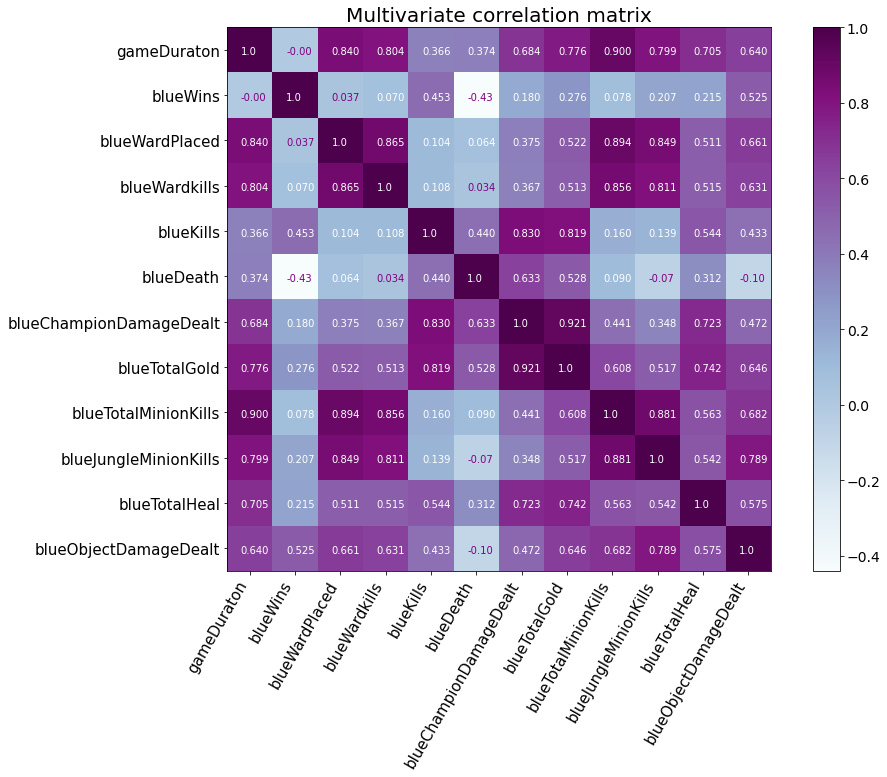

In [10]:
plt.figure(figsize=(15, 10))
corr_m = np.array(source_df.corr())
# print(corr_m)
plt.imshow(corr_m, cmap='BuPu')
ax = plt.subplot()
for i in range(0, 12):
    for j in range(0, 12):
        if corr_m[i,j]<0.05:
                ax.text(-0.2+i, 0.1+j, str(corr_m[i,j])[:5], fontsize = 10, color='purple')
        else:
                ax.text(-0.2+i, 0.1+j, str(corr_m[i,j])[:5], fontsize = 10, color='white')
        # ax.text(0.6, 0.1, str(corr_m[1,0])[:5], fontsize = 20)
# plt.matshow(source_df.corr(), fignum=f.number)
plt.yticks(range(source_df.select_dtypes(['number']).shape[1]), source_df.select_dtypes(['number']).columns, fontsize=15)
plt.xticks(range(source_df.select_dtypes(['number']).shape[1]), source_df.select_dtypes(['number']).columns, fontsize=15, rotation=60, horizontalalignment='right')
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Multivariate correlation matrix', fontsize=20)

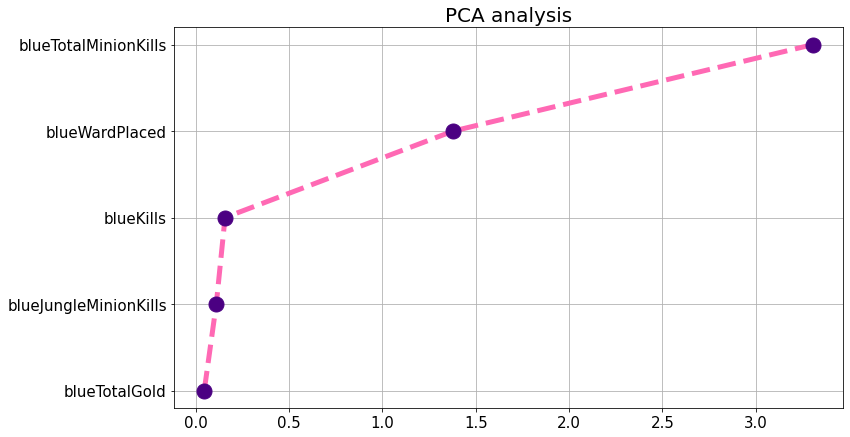

In [11]:
w = ['gameDuraton',
    'blueWardPlaced',
    'blueWardkills', 
    'blueKills', 
    'blueDeath', 
    'blueChampionDamageDealt', 
    'blueTotalGold', 
    'blueTotalMinionKills', 
    'blueJungleMinionKills',
    'blueTotalHeal',
    'blueObjectDamageDealt']
pca_df = source_df[['blueTotalMinionKills', 
                    'blueWardPlaced',
                    'blueKills',                    
                    'blueJungleMinionKills',
                    'blueTotalGold',]]
pca_vars = sk.preprocessing.scale(pca_df)
pca_vars = pd.DataFrame(pca_vars, index=pca_df.index, columns=pca_df.columns)

plt.figure(figsize=(12,7))
pca = PCA().fit(pca_vars)
x = np.std(pca.transform(pca_vars), axis=0)**2
y = - np.arange(len(x)) - 1
plt.plot(x, y, "o", markersize=15, markerfacecolor='indigo', markeredgecolor='indigo', linewidth=5, linestyle='--', color='hotpink')
plt.grid(True)
plt.yticks(y, pca_vars.columns, fontsize=15)
plt.xticks(fontsize=15)
plt.title('PCA analysis', fontsize=20)
plt.show()

## Exercise №6
Build regression model and make an analysis of multicollinearity and regularization (if needed). 

In [12]:
from math import inf

In [13]:
train, test = sk.model_selection.train_test_split (source_df[['gameDuraton', 
                                                            'blueTotalMinionKills', 
                                                            'blueWardPlaced',
                                                            'blueKills',                    
                                                            'blueJungleMinionKills']].copy(), 
                                                                        test_size=0.15, random_state=42)

X_train= train[['blueTotalMinionKills', 'blueWardPlaced', 'blueKills', 'blueJungleMinionKills']]
X_test= test[['blueTotalMinionKills', 'blueWardPlaced', 'blueKills', 'blueJungleMinionKills']]
y_train= train['gameDuraton']
y_test= test['gameDuraton']

random_state=1
table = PrettyTable()
table.field_names = ["Type", "Alpha", "MSE", "VAR", "Coeff"]

lin_r = sk.linear_model.LinearRegression()
lin_r.fit(X_train, y_train)
predicted = lin_r.predict(X_test)
table.add_row(["Least Squares model", "-" , str(mean_squared_error(y_test, predicted)), str(r2_score(y_test, predicted)), str(lin_r.coef_)])

best_lasso_alpha = -1
best_lasso_mse = inf
best_lasso_r2 = -1
best_lasso_coef = (0, 0, 0, 0)
for alpha in np.arange(0.0,1.001,0.001):
  lin_r = sk.linear_model.Lasso(alpha=alpha, random_state=random_state)
  lin_r.fit(X_train, y_train)
  predicted = lin_r.predict(X_test)
  curr_lasso_mse = mean_squared_error(y_test, predicted)
  curr_lasso_r2 = r2_score(y_test, predicted)
  curr_lasso_coef = lin_r.coef_
  if curr_lasso_mse < best_lasso_mse and curr_lasso_r2 > best_lasso_r2:
    best_lasso_alpha = alpha
    best_lasso_mse = curr_lasso_mse
    best_lasso_r2 = curr_lasso_r2
    best_lasso_coef = curr_lasso_coef

table.add_row(["Best Lasso model", best_lasso_alpha ,str(best_lasso_mse), str(best_lasso_r2), str(best_lasso_coef)])

best_ridge_alpha = -1
best_ridge_mse = inf
best_ridge_r2 = -1
best_ridge_coef = (0, 0, 0, 0)
for alpha in np.arange(0.0,1.001,0.001):
  lin_r = sk.linear_model.Ridge(alpha=alpha, random_state=random_state)
  lin_r.fit(X_train, y_train)
  predicted = lin_r.predict(X_test)
  curr_ridge_mse = mean_squared_error(y_test, predicted)
  curr_ridge_r2 = r2_score(y_test, predicted)
  curr_ridge_coef = lin_r.coef_
  if curr_ridge_mse < best_ridge_mse and curr_ridge_r2 > best_ridge_r2:
    best_ridge_alpha = alpha
    best_ridge_mse = curr_ridge_mse
    best_ridge_r2 = curr_ridge_r2
    best_ridge_coef = curr_ridge_coef

table.add_row(["Best Ridge model", best_ridge_alpha ,str(best_ridge_mse), str(best_ridge_r2), str(best_ridge_coef)])

print(table)

C:\Temp/ipykernel_5140/2748455849.py:28: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr.fit(X_train, y_train)
C:\Users\Alex\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\Alex\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.243e+04, tolerance: 1.144e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast

+---------------------+-------+-------------------+--------------------+---------------------------------------------------+
|         Type        | Alpha |        MSE        |        VAR         |                       Coeff                       |
+---------------------+-------+-------------------+--------------------+---------------------------------------------------+
| Least Squares model |   -   |  6.45854931618741 | 0.863471817740373  | [ 0.02757635  0.05211538  0.12925268 -0.00398877] |
|   Best Lasso model  |  0.21 | 6.457948868209419 | 0.8634845106946206 | [ 0.02764219  0.05080485  0.12786313 -0.00351737] |
|   Best Ridge model  |  1.0  | 6.458549298567674 | 0.863471818112839  | [ 0.02757635  0.05211536  0.12925264 -0.00398877] |
+---------------------+-------+-------------------+--------------------+---------------------------------------------------+


## Exercise №7
Analyze the quality of regression model (distribution of residuals, determination coefficient).

In [14]:
model = sk.linear_model.LinearRegression()
model.fit(X_train, y_train)
predicted = model.predict(X_test)

residuals = source_df[target] - model.predict(source_df[predictors])

residuals.describe()

result = sp.stats.anderson(residuals, dist='norm')
print('Statistic: %.3f' % result.statistic)
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.1f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.1f: %.3f, data does not look normal (reject H0)' % (sl, cv))

sp.stats.kstest(residuals, 'norm', args=(residuals.mean(), residuals.var())) 

fig, axes = plt.subplots(1, 2, figsize=(18, 8))  
sns.kdeplot(residuals, shade=True, color='purple', ax=axes[0])
sp.stats.probplot(residuals, dist="norm", plot=axes[1])
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
pylab.show()


NameError: name 'target' is not defined